In [93]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white')

from sklearn.preprocessing import StandardScaler
import imblearn
from imblearn import over_sampling

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [48]:
!pwd

/Users/samrudovsky/Desktop/Metis/Projects/Project_3/notebooks


In [49]:
# load cleaned data from EDA notebook

with open("../pickles-csv/df.pkl", 'rb') as f: 
    df = pickle.load(f)

### Set up data for modeling

In [50]:
X, y = (df.iloc[:,:-1], df.iloc[:, -1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
# Normalize data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Address class imbalance by oversampling the positive class

In [52]:
n_pos = np.sum(y_train == 1) # 7665 observations
n_neg = np.sum(y_train == 0) # 60629 observations
ratio = {1 : n_pos * 8, 0 : n_neg}

ROS = imblearn.over_sampling.RandomOverSampler(ratio = ratio) 
    
X_train, y_train = ROS.fit_sample(X_train, y_train)

### Logistic Regression

In [53]:
logistic = LogisticRegression(solver='liblinear', C= .5, penalty='l1') 
logistic.fit(X_train, y_train)
y_pred_logistic = logistic.predict(X_test)

In [ ]:
# Cross validate to tune hyperparameters

param_grid_log = {
                 'C': [.5, 1, 5],
                 'penalty': ['l1', 'l2']
             }

auc_score = make_scorer(roc_auc_score) # Optimize AUC

logistic = RandomizedSearchCV(logistic, param_grid_log, cv=2, scoring = auc_score, verbose=True)
logistic.fit(X_train, y_train)

In [ ]:
logistic.best_params_

In [54]:
y_proba_logistic = logistic.predict_proba(X_test)[:,1]
fpr_logistic, tpr_logistic, thresh = roc_curve(y_test, y_proba_logistic)

print('AUC:', auc(fpr_logistic, tpr_logistic))
print('F1 Score:', f1_score(y_test, y_pred_logistic))
print('F 1.5 Score:', fbeta_score(y_test, y_pred_logistic, 1.5))
print('Recall:', recall_score(y_test, y_pred_logistic))
print('Precision:', precision_score(y_test, y_pred_logistic))
print('Accuracy:', accuracy_score(y_test, y_pred_logistic))

AUC: 0.6548730319893658
F1 Score: 0.27053421762262225
F 1.5 Score: 0.33710565289071454
Recall: 0.5560215698022768
Precision: 0.17875373206202447
Accuracy: 0.6580457806627946


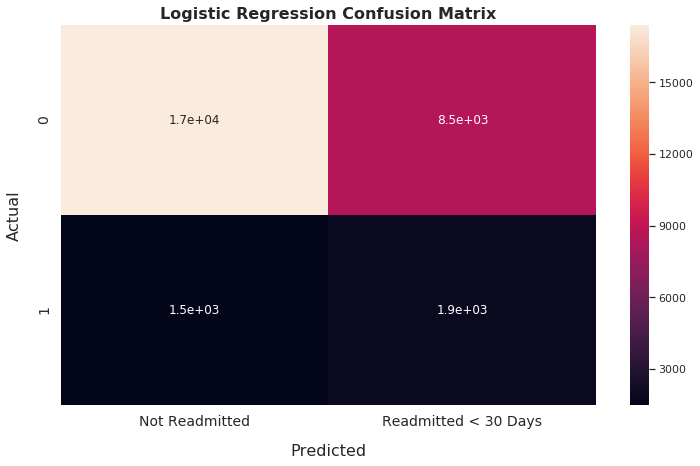

In [55]:
'''Logistic confusion matrix with oversampling. 
Not a perfect model, but it does a decent job at
minimizing false negatives (optimizing for recall)
'''

plt.figure(figsize=(12, 7))

cm_logistic = confusion_matrix(y_test, y_pred_logistic)
ax = sns.heatmap(cm_logistic, annot=True, cbar=True,
                xticklabels = ['Not Readmitted', 'Readmitted < 30 Days'])

ax.tick_params(labelsize=14)

plt.title('Logistic Regression Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, labelpad=15)
plt.ylabel('Actual', fontsize=16, labelpad=15);

plt.savefig('../figures/LogisticRegressionConfusionMatrix.png', bbox_inches='tight')

### Random Forest

In [56]:
forest = RandomForestClassifier(n_estimators = 600, max_depth=12)

forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

In [ ]:
# Tune hyperparameters

param_grid_forest = {
                 'n_estimators': range(100, 900, 100),
                 'max_depth': range(4, 20, 2),
             }

forest = RandomizedSearchCV(forest, param_grid_forest, n_iter=20, cv=2, scoring=auc_score, verbose=True)
forest.fit(X_train, y_train)

In [ ]:
forest.best_params_

In [57]:
y_proba_forest = forest.predict_proba(X_test)[:,1]
fpr_forest, tpr_forest, thresh = roc_curve(y_test, y_proba_forest)

print('Forest AUC:', auc(fpr_forest, tpr_forest))
print('Forest F1 Score:', f1_score(y_test, y_pred_forest))
print('Forest F 1.5 Score:', fbeta_score(y_test, y_pred_forest, 1.5))
print('Forest Recall:', recall_score(y_test, y_pred_forest))
print('Forest Precision:', precision_score(y_test, y_pred_forest))
print('Forest Accuracy:', accuracy_score(y_test, y_pred_forest))

Forest AUC: 0.6624499532214363
Forest F1 Score: 0.2733070148800486
Forest F 1.5 Score: 0.3372827120989363
Forest Recall: 0.5392450569203115
Forest Precision: 0.18303843807199513
Forest Accuracy: 0.6729757430816535


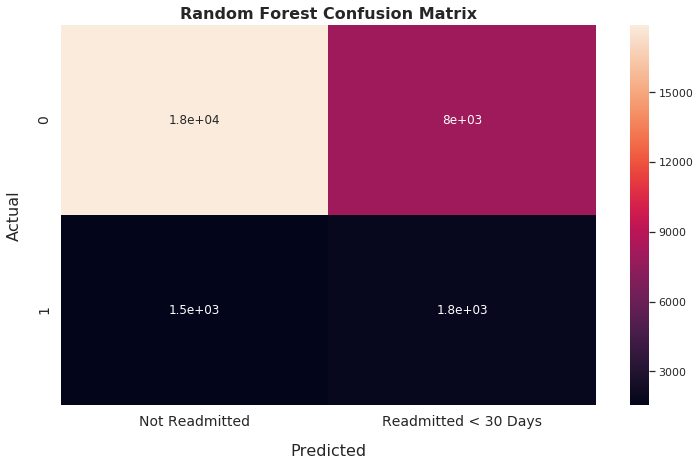

In [58]:
'''
Random Forest confusion matrix. This is the best distribution. 
High false positive rate is okay. The model optimizes for recall and AUC.
Captures ~58% of readmissions. Don't want patients to slip through the cracks. 
'''

plt.figure(figsize=(12, 7))

cm_forest = confusion_matrix(y_test, y_pred_forest)
ax = sns.heatmap(cm_forest, annot=True, cbar=True, 
                 xticklabels = ['Not Readmitted', 'Readmitted < 30 Days'])
ax.tick_params(labelsize=14)

plt.title('Random Forest Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=16, labelpad=15)
plt.ylabel('Actual', fontsize=16, labelpad=15);

plt.savefig('../figures/RandomForestConfusionMatrix.png', bbox_inches='tight')

In [59]:
# Most Important Features in Random Forest Model

feat_importance = []

for feature in zip(df.columns, forest.feature_importances_):
    feat_importance.append(feature)
    
most_important_features = sorted(feat_importance, key = lambda x: x[1])[-10:]
most_important_features

[('number_outpatient', 0.02057043566475384),
 ('num_procedures', 0.021656812400472694),
 ('Discharged_to_Rehab_facility', 0.037923892452665545),
 ('time_in_hospital', 0.040610584452859304),
 ('number_diagnoses', 0.04122748570659418),
 ('num_lab_procedures', 0.04409184184453281),
 ('number_emergency', 0.04417080739132768),
 ('num_medications', 0.049010303999571514),
 ('Discharged_to_Home', 0.05884864988876492),
 ('number_inpatient', 0.1921148703703596)]

In [60]:
most_important_features_df = pd.DataFrame(most_important_features,
                                             columns=['Feature', 'Importance'])

most_important_features_df.iloc[::-1]
most_important_features_df.iloc[0, 0] = 'Discharged to Skilled Nursing Facility'
most_important_features_df.iloc[1, 0] = 'Number of Medical Procedures During Encounter'
most_important_features_df.iloc[2, 0] = 'Discharged to Rehab Facility'
most_important_features_df.iloc[3, 0] = 'Time Spent in Hospital'
most_important_features_df.iloc[4, 0] = 'Number of Lab Procedures During Encounter'
most_important_features_df.iloc[5, 0] = 'Number of Diagnoses in Patient Chart'
most_important_features_df.iloc[6, 0] = 'Number of Medications Administered During Encounter'
most_important_features_df.iloc[7, 0] = 'Number of ER Visits Prior to Encounter'
most_important_features_df.iloc[8, 0] = 'Discharged Home'
most_important_features_df.iloc[9, 0] = 'Number of Inpatient Visits Prior to Encounter'

most_important_features_df = most_important_features_df.iloc[::-1]

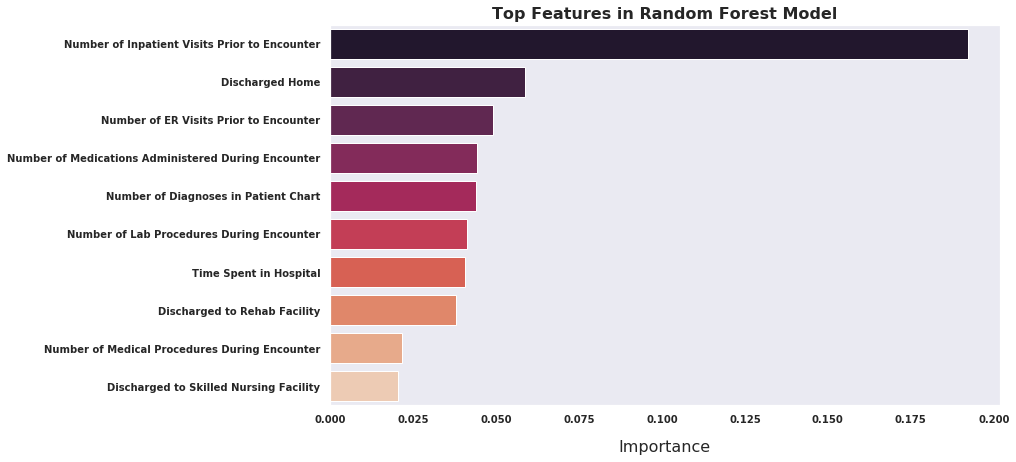

In [61]:
plt.figure(figsize=(12, 7))

sns.set(style='dark')
ax = sns.barplot(x='Importance', y='Feature', data=most_important_features_df, palette='rocket')

plt.title('Top Features in Random Forest Model', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=16, labelpad=15)
plt.ylabel(None)
plt.xticks(fontweight=600)
plt.yticks(fontweight=600)
ax.tick_params(labelsize=10);

plt.savefig('../figures/RandomForestFeatureImportance.png', bbox_inches='tight')

### XGBoost

In [62]:
boost = XGBClassifier(n_estimators=700, 
                        max_depth=18,
                        objective='binary:logistic',
                        learning_rate=.05, 
                        subsample=.9,
                        min_child_weight=1,
                        colsample_bytree=.8)

boost.fit(X_train, y_train,
        eval_metric='auc')

y_pred_boost = boost.predict(X_test)

In [ ]:
# Tune hyperparameters

param_grid_boost = {
    'max_depth': range(6, 12, 4),
    'learning_rate': [.01, .02, .03, .04, .05],
    'min_child_weight': [1, 2, 3],
}

boost = RandomizedSearchCV(boost, param_grid_boost, n_iter=15, cv=2, scoring='roc_auc', verbose=True)
# boost.fit(X_train, y_train)

In [63]:
boost.best_params_

AttributeError: 'XGBClassifier' object has no attribute 'best_params_'

In [64]:
y_proba_boost = boost.predict_proba(X_test)[:,1]
fpr_boost, tpr_boost, thresh = roc_curve(y_test, y_proba_boost)

print('Boost AUC:', auc(fpr_boost, tpr_boost))
print('Boost F1 Score:', f1_score(y_test, y_pred_boost))
print('Boost F 1.5 Score:', fbeta_score(y_test, y_pred_boost, 1.5))
print('Boost Recall:', recall_score(y_test, y_pred_boost))
print('Boost Precision:', precision_score(y_test, y_pred_boost))
print('Boost Accuracy:', accuracy_score(y_test, y_pred_boost))

Boost AUC: 0.6108689851791943
Boost F1 Score: 0.12041757708181597
Boost F 1.5 Score: 0.09720798408008201
Boost Recall: 0.07429598562013182
Boost Precision: 0.3175416133162612
Boost Accuracy: 0.8762213870857534


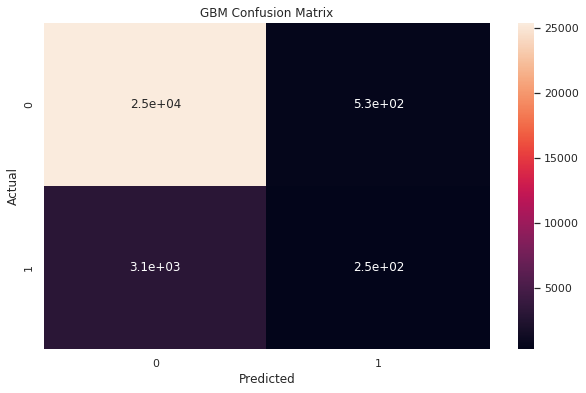

In [65]:
### Confusion Matrix

plt.figure(figsize=(10, 6))

cm_boost = confusion_matrix(y_test, y_pred_boost)
ax = sns.heatmap(cm_boost, annot=True)
ax.set(title = 'GBM Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Naive Bayes,  Decision Tree

In [66]:
# Naive Bayes 

bayes = GaussianNB()
bayes.fit(X_train, y_train)
y_pred_bayes = bayes.predict(X_test)

In [67]:
y_proba_bayes = bayes.predict_proba(X_test)[:,1]
fpr_bayes, tpr_bayes, thresh = roc_curve(y_test, y_proba_bayes)
print('Naive Bayes AUC:', auc(fpr_bayes, tpr_bayes))
print('Naive Bayes F1 Score:', f1_score(y_test, y_pred_bayes))
print('Naive Bayes F 1.5 Score:', fbeta_score(y_test, y_pred_bayes, 1.5))
print('Naive Bayes Recall:', recall_score(y_test, y_pred_bayes))
print('Naive Bayes Precision:', precision_score(y_test, y_pred_bayes))
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_bayes))

Naive Bayes AUC: 0.5032330200468071
Naive Bayes F1 Score: 0.20553433336439017
Naive Bayes F 1.5 Score: 0.29567793464663267
Naive Bayes Recall: 0.9913121629718394
Naive Bayes Precision: 0.11465299192682166
Naive Bayes Accuracy: 0.12603348138025283


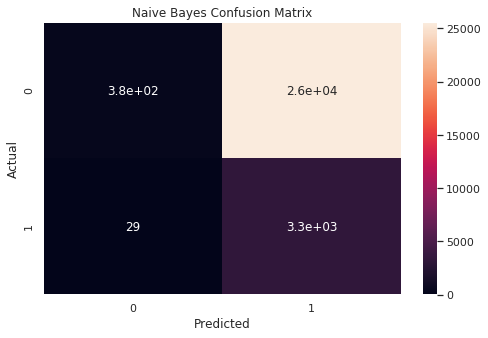

In [68]:
'''Naive confusion matrix
Clearly not a viable model'''

plt.figure(figsize=(8, 5))

cm_neighbors = confusion_matrix(y_test, y_pred_bayes)
ax = sns.heatmap(cm_neighbors, annot=True)
ax.set(title = 'Naive Bayes Confusion Matrix', xlabel='Predicted', ylabel='Actual');

In [69]:
# Decision Tree

tree = DecisionTreeClassifier(max_depth=8)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [70]:
y_proba_tree = tree.predict_proba(X_test)[:,1]
fpr_tree, tpr_tree, thresh = roc_curve(y_test, y_proba_tree)
print('DT AUC:', auc(fpr_tree, tpr_tree))
print('DT F1 Score:', f1_score(y_test, y_pred_tree))
print('DT F 1.5 Score:', fbeta_score(y_test, y_pred_tree, 1.5))
print('DT Recall:', recall_score(y_test, y_pred_tree))
print('DT Precision:', precision_score(y_test, y_pred_tree))
print('DT Accuracy:', accuracy_score(y_test, y_pred_tree))

DT AUC: 0.6343763167012735
DT F1 Score: 0.25836232271875836
DT F 1.5 Score: 0.32822101932480846
DT Recall: 0.5784901138406231
DT Precision: 0.16632213608957794
DT Accuracy: 0.6212504270584216


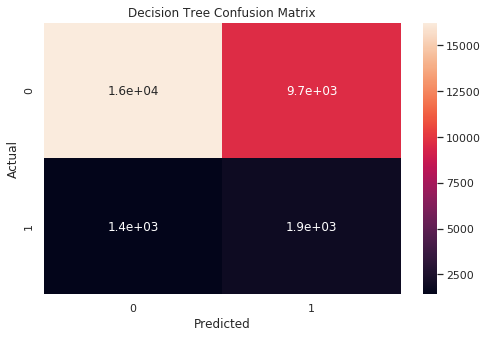

In [71]:
'''Decision Tree confusion matrix
Far less precise than logistic, random forest, and xgboost models
'''

plt.figure(figsize=(8, 5))

cm_neighbors = confusion_matrix(y_test, y_pred_tree)
ax = sns.heatmap(cm_neighbors, annot=True)
ax.set(title = 'Decision Tree Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### KNN/SVC not viable for this problem

In [ ]:
### KNN (computationally expensive – lower AUC and recall scores)

# neighbors = KNeighborsClassifier(n_neighbors=10)
# neighbors.fit(X_train_ros, y_train_ros)
# y_prediction_neighbors = neighbors.predict(X_test)

In [ ]:
# # KNN confusion matrix

# plt.figure(figsize=(8, 5))

# cm_neighbors = confusion_matrix(y_test, y_prediction_neighbors)
# ax = sns.heatmap(cm_neighbors, annot=True)
# ax.set(title = 'KNN Confusion Matrix', xlabel='Predicted', ylabel='Actual');

In [ ]:
### Support Vector Classifier (Computationaly expensive)

# svm = SVM()
# svm.fit(X_train, y_train)
# y_prediction_svm = svm.predict(X_test)

### Compare and visualize model performance

In [72]:
model_list = [logistic, bayes, tree, forest, boost] # Not including SVC, Decision Tree, or KNN models

accuracy = []
precision = []
recall = []
f1 = []
cross_val = []

def modelScores(models):
    for model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        cross_val.append(np.mean(cross_val_score(model, X, y)))
    
    return accuracy, precision, recall, f1, cross_val

scores = modelScores(model_list)

In [73]:
# Convert lists to DataFrame

score_df = pd.DataFrame(list(scores))
score_df = score_df.T
                    
score_df.index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Gradient Boost']
score_df.columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Cross_val_score']

score_df

,Accuracy,Precision,Recall,F1,Cross_val_score
Logistic Regression,0.658080,0.178709,0.555722,0.270448,0.886618
Naive Bayes,0.126033,0.114653,0.991312,0.205534,0.147318
Decision Tree,0.621216,0.166365,0.578790,0.258444,0.884958
Random Forest,0.673659,0.184633,0.544937,0.275815,0.887202
Gradient Boost,0.876221,0.317542,0.074296,0.120418,0.885573


In [94]:
# Assign AUC for different models

fpr_values = []
tpr_values = []
auc_values = []

def modelProba(models):

    for model in models:
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresh = roc_curve(y_test, y_proba)
        fpr_values.append(fpr)
        tpr_values.append(tpr)
        auc_values.append(metrics.auc(fpr, tpr))
    
    return auc_values

proba = modelProba(model_list)

In [95]:
# Build a DataFrame with each model's AUC

proba_df = pd.DataFrame(proba,
                        index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 
                               'Random Forest', 'Gradient Boosting'],
                        columns=['AUC'])

In [96]:
# Merge AUC to original scoring metrics DataFrame

all_scores = pd.concat([score_df, proba_df], axis=1)

all_scores

,Accuracy,Precision,Recall,F1,Cross_val_score,AUC
Decision Tree,0.621216,0.166365,0.578790,0.258444,0.884958,0.634598
Gradient Boost,0.876221,0.317542,0.074296,0.120418,0.885573,NaN
Gradient Boosting,NaN,NaN,NaN,NaN,NaN,0.610869
Logistic Regression,0.658080,0.178709,0.555722,0.270448,0.886618,0.654875
Naive Bayes,0.126033,0.114653,0.991312,0.205534,0.147318,0.503233
Random Forest,0.673659,0.184633,0.544937,0.275815,0.887202,0.663639


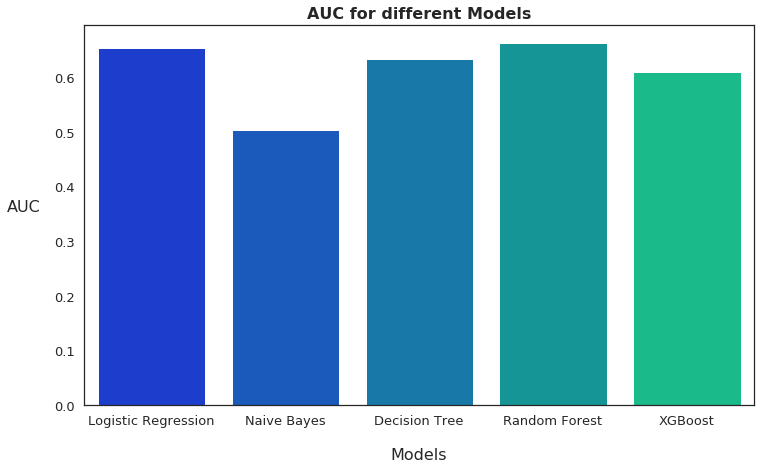

In [97]:
### Compare models

models = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']

# model_list = [logistic, bayes, tree, forest, boost]

plt.figure(figsize=(12, 7))

sns.set(style='white')
sns.barplot(x = models, y = proba, data=proba_df, palette= 'winter');

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Models', labelpad=20, fontsize=16)
plt.ylabel('AUC', rotation='0', labelpad=30, fontsize=16)
plt.title('AUC for different Models', fontsize=16, fontweight='bold')

plt.savefig('AUC.png', bbox_inches='tight');

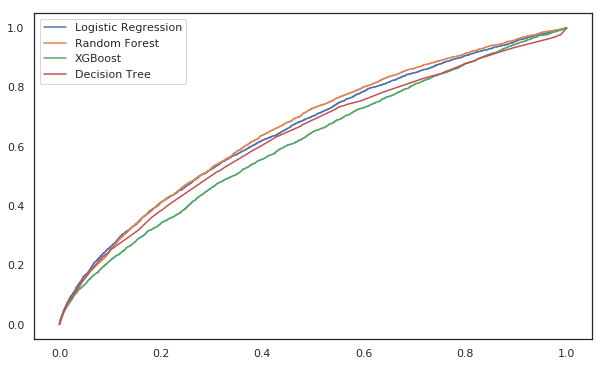

In [98]:
plt.figure(figsize=(10,6))

plt.plot(fpr_logistic, tpr_logistic) # logistic
plt.plot(fpr_forest, tpr_forest) # random foreset
plt.plot(fpr_boost, tpr_boost) # xgboost
plt.plot(fpr_tree, tpr_tree) # decision tree
plt.legend(['Logistic Regression', 'Random Forest', 'XGBoost', 'Decision Tree']);